# 0. Imports and constants (run config)

In [2]:
from copy import deepcopy

from copulae.archimedean import ClaytonCopula, FrankCopula, GumbelCopula
from copulae.elliptical import GaussianCopula, StudentCopula
from cvxpy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from scipy.integrate import simps
from scipy.stats import bootstrap, norm
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import Pipeline
from statsmodels.nonparametric.bandwidths import bw_silverman, bw_scott

from components.transformers.rate_transformer import RateTransformer
from components.transformers.log_transformer import LognTransformer

In [3]:
X_TRAIN_START = '2010-01-01'
X_TRAIN_END = '2022-12-30'
X_TEST_START = '2023-01-02'
X_TEST_END = '2023-02-28'


SELECTED_PORTFOLIOS = {
    'P1': ['Nickel', 'Copper'],
    'P2': ['Brent Oil', 'Gas US'],
    'P3': ['Gold', 'Silver'],
    'P4': ['Nickel', 'Copper', 'Gold'],
    'P5': ['Nickel', 'Copper', 'Silver'],
    'P6': ['Brent Oil', 'Gas US', 'Gold'],
    'P7': ['Brent Oil', 'Gas US', 'Silver']
}

SELECTED_BENCHMARK = 'SPGSCI'

# KDE configuration
# 'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine',
KERNEL = 'epanechnikov'
# 'silverman', 'scott', float
KERNEL_BANDWIDTH = 'silverman'

# Copula
# 'gaussian', 'student', 'frank', 'clayton', 'gumbel'
COPULA = 'student'
# N_COPULA_SIMULATIONS = 10000
RANDOM_SEED = 5

# Portfolio simulations
WEIGHT_SIMULATIONS = 10000

# 1. Data load and prep

In [4]:
# load prices from dataset
df = pd.read_excel('data/BazaMSA.xlsx', sheet_name='Ceny')
# Dates as index
df.set_index('Dates', inplace=True)

# Comprehensive scikitlearn `Pipeline` that first creates the rates
# and then performs logn on top
log_rate_pipe = Pipeline(
    steps=[
        ('rates', RateTransformer(period=1)),
        ('logn', LognTransformer())
    ]
)
df_transformed = log_rate_pipe.fit_transform(X=df)
# Drop all the `na` values
df_transformed.dropna(inplace=True)

# Select dataset to train (fit) and test
X_train = df_transformed.loc[X_TRAIN_START:X_TRAIN_END]
X_test = df_transformed.loc[X_TEST_START:X_TEST_END]

f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


# 2. Kernel density estimation

In [5]:
def get_cdf(x_value: float, cdf_function: [np.array, list], x_range: [np.array, list]):
    index = np.abs(x_range-x_value).argmin()
    return cdf_function[index]

def get_inverse_cdf(cdf_value: float, cdf_function: [np.array, list], x_range: [np.array, list]):
    index = np.abs(cdf_function-cdf_value).argmin()
    return x_range[index]

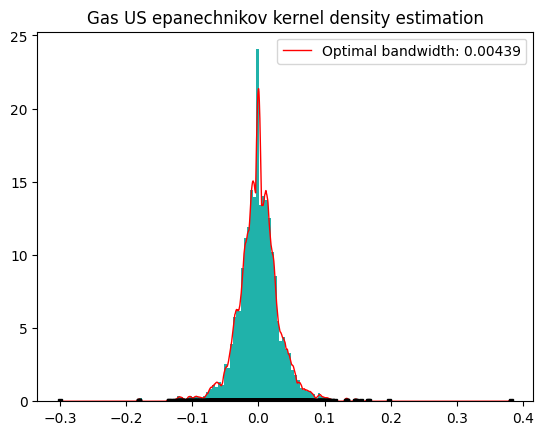

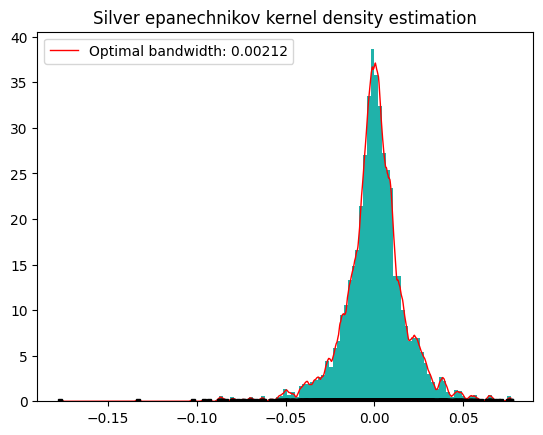

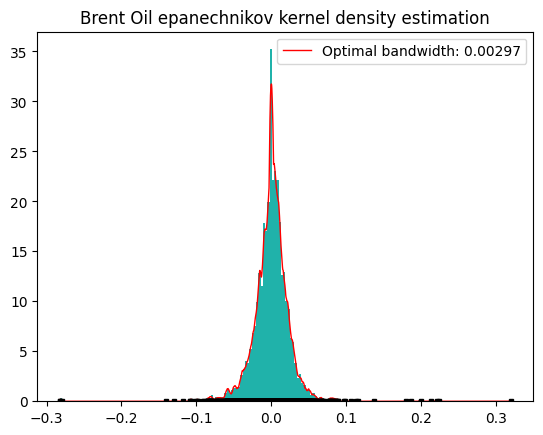

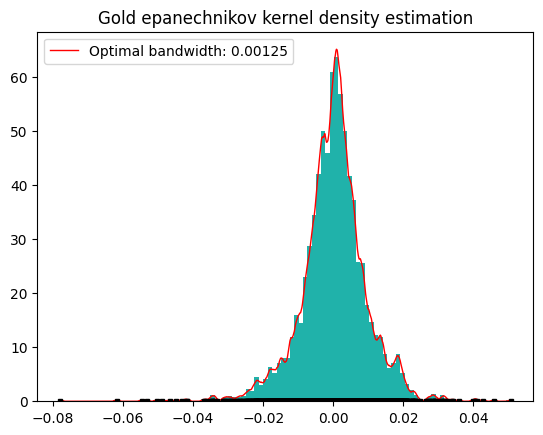

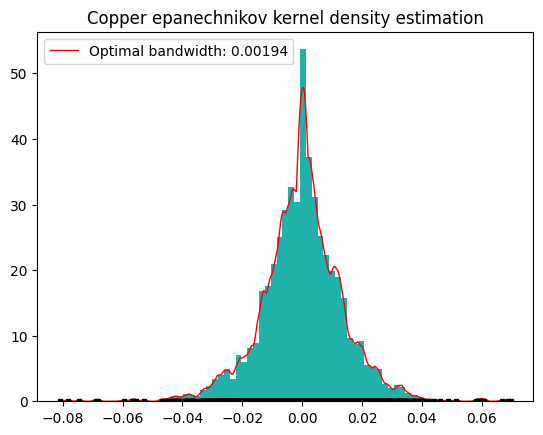

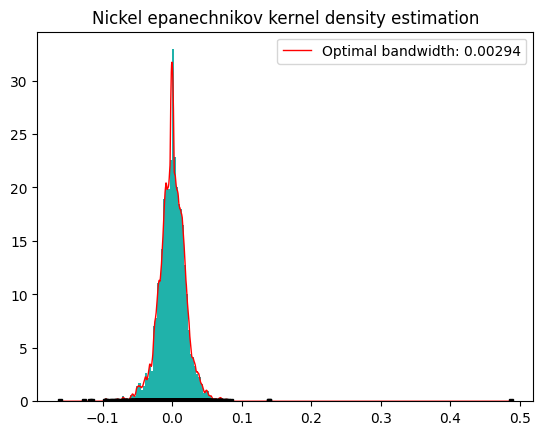

In [6]:
df_kernel_density = pd.DataFrame()
df_kernel_cdf = pd.DataFrame()
df_kernel_xrange = pd.DataFrame()
X_train_kernel_cdf = pd.DataFrame()
for asset in set([i for j in SELECTED_PORTFOLIOS.values() for i in j]):
    # KernelDensity requires 2D array, so need to reshape
    dist = X_train[asset].to_numpy().reshape(-1, 1)

    optimized_metrics = {}
    optimized_metrics['silverman'] = bw_silverman(X_train[asset])
    optimized_metrics['scott'] = bw_scott(X_train[asset])

    if KERNEL_BANDWIDTH in ['silverman', 'scott']:
        bandwidth = optimized_metrics[KERNEL_BANDWIDTH]
    else:
        bandwidth = KERNEL_BANDWIDTH

    # x-value range for plotting
    x_range = np.linspace(dist.min(), dist.max(), len(X_train))

    # fitting KDE
    kde = KernelDensity(kernel=KERNEL, bandwidth=bandwidth).fit(dist)
    # compute the log-likelihood of each sample
    log_density = kde.score_samples(x_range.reshape(-1,1))

    # Calculate cdf based on estimated kernel density
    cdf = np.exp(log_density).cumsum()
    # normalize the cdf to have values [0,1]
    normalized_cdf = cdf/cdf[-1]

    plt.title(f'{asset} {KERNEL} kernel density estimation')
    plt.hist(X_train[asset], density=True, color='lightseagreen', bins='auto')
    plt.plot(x_range, np.exp(log_density), color='red', linewidth=1, label=f'Optimal bandwidth: {round(bandwidth,5)}')
    plt.plot(dist, np.zeros_like(dist) , 's', markersize=3, color='black')
    plt.legend()
    plt.show()

    df_kernel_density[asset] = np.exp(log_density)
    df_kernel_cdf[asset] = normalized_cdf
    df_kernel_xrange[asset] = x_range
    X_train_kernel_cdf[asset] = X_train[asset].apply(
        lambda x_value: get_cdf(x_value, normalized_cdf, x_range)
    )

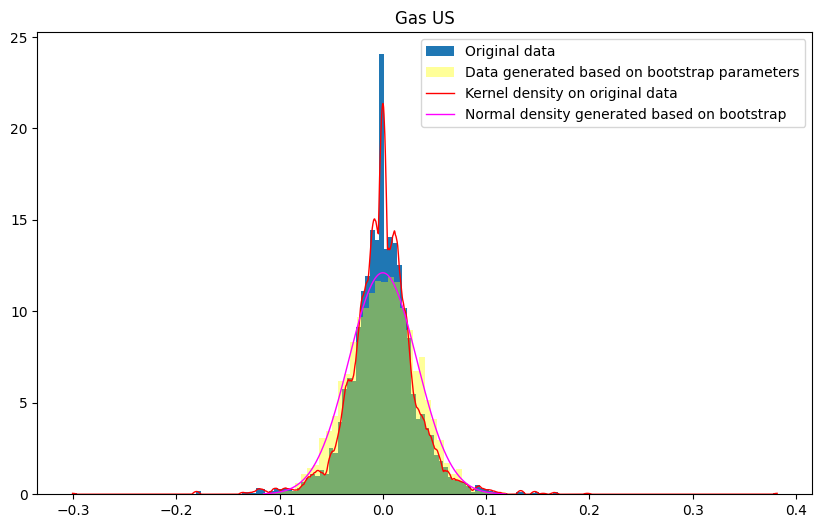

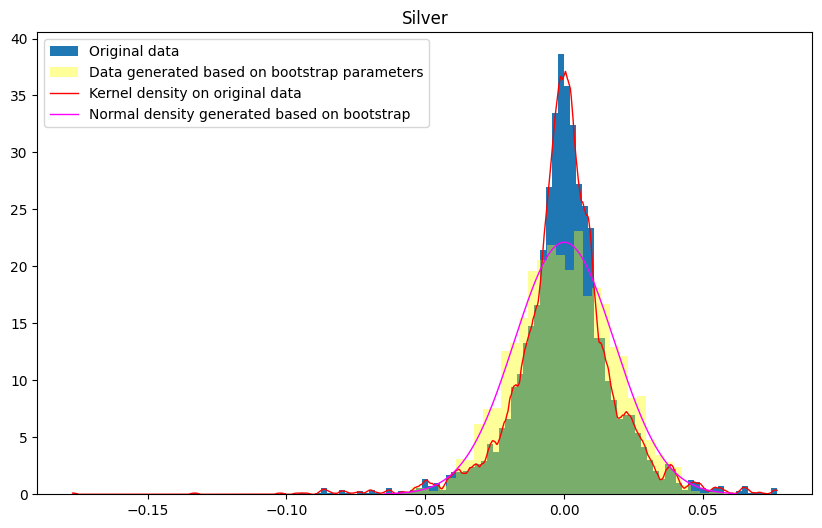

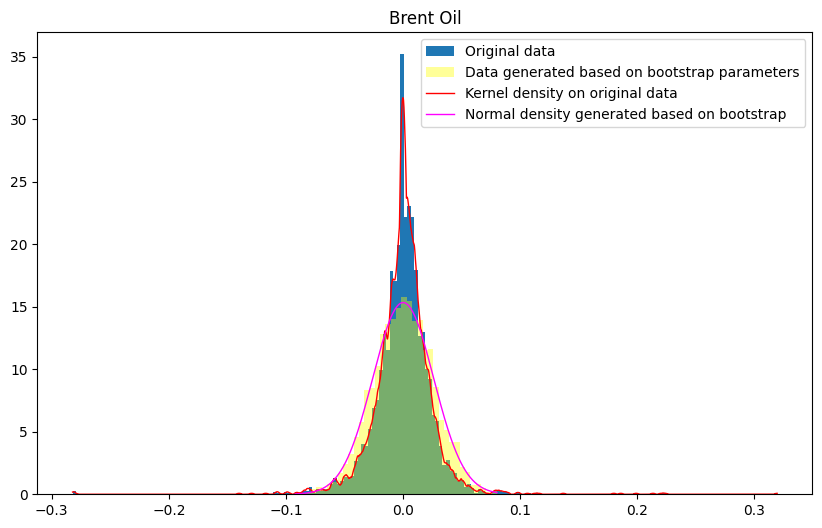

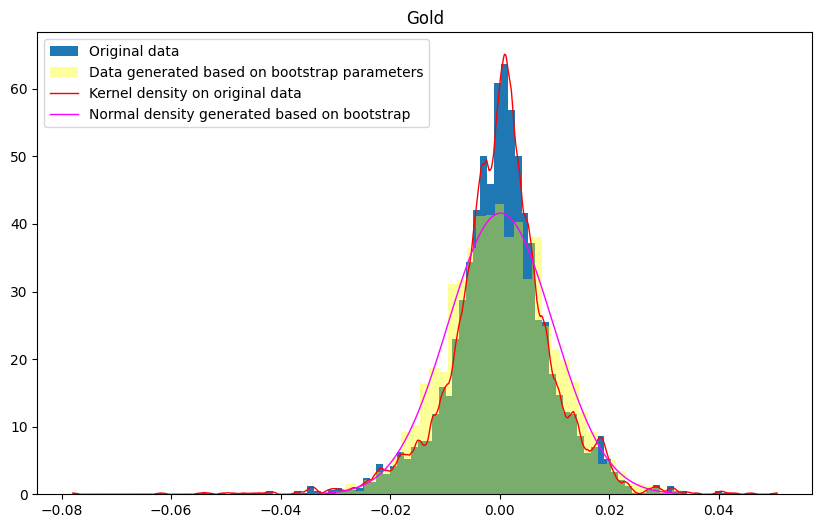

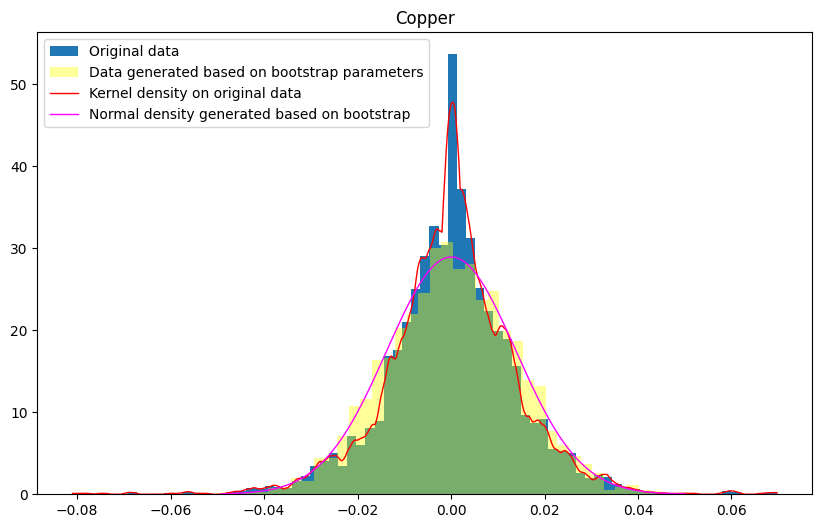

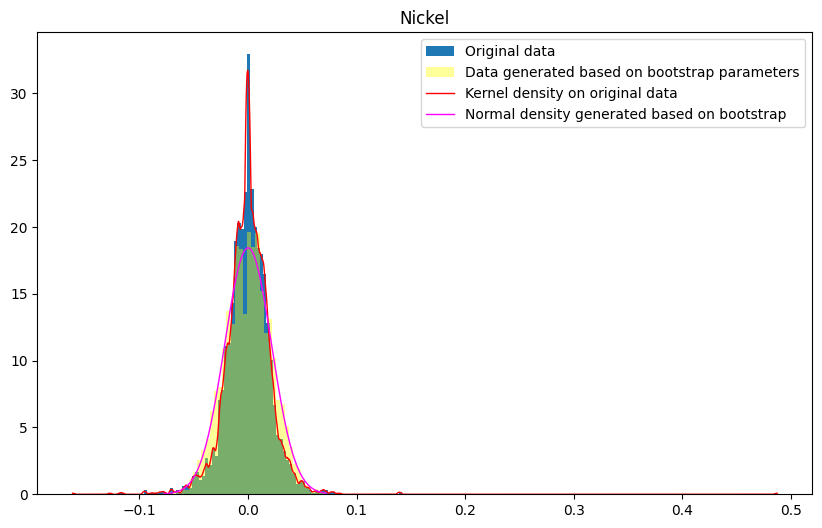

,Asset,MSE,MISE
0,Gas US,20.539918,14.016724
1,Silver,128.862206,32.711042
2,Brent Oil,43.720465,26.320182
3,Gold,229.666505,29.558853
4,Copper,49.786035,7.508187
5,Nickel,102.269081,66.372192


In [7]:
np.random.seed(RANDOM_SEED)

df_kernel_fit_metrics_df = pd.DataFrame()
for asset in set([i for j in SELECTED_PORTFOLIOS.values() for i in j]):
    log_returns = (X_train[asset],)
    # First do bootstrap based on logreturns from variable
    bootstrap_mean = bootstrap(log_returns, np.mean, confidence_level=0.9, random_state=RANDOM_SEED)
    bootstrap_std = bootstrap(log_returns, np.std, confidence_level=0.9, random_state=RANDOM_SEED)

    # Draw random variables based on bootstrap parameters
    rndm = np.random.normal(
        loc=np.median(bootstrap_mean.bootstrap_distribution),
        scale=np.median(bootstrap_std.bootstrap_distribution),
        size=len(X_train))
    
    # x-value range for plotting
    dist_original = X_train[asset].to_numpy().reshape(-1, 1)
    x_range_original = np.linspace(dist_original.min(), dist_original.max(), len(X_train))
    dist_generated = rndm.reshape(-1,1)
    x_range_generated = np.linspace(dist_generated.min(), dist_generated.max(), len(X_train))

    pdf_generated_values = norm.pdf(
        x=x_range_generated,
        loc=np.median(bootstrap_mean.bootstrap_distribution),
        scale=np.median(bootstrap_std.bootstrap_distribution))
    
    mse = mean_squared_error(df_kernel_density[asset], pdf_generated_values)
    #df_kernel_fit_metrics_df[asset] = round(mse, 2)

    x_range_total = np.linspace(
        min([x_range_original[0], x_range_generated[0]]).value,
        max([x_range_original[-1], x_range_generated[-1]]).value,
        len(X_train))
    mise = simps((df_kernel_density[asset]-pdf_generated_values)**2, x_range_total)

    row = pd.DataFrame({
        'Asset': [asset],
        'MSE': [mse],
        'MISE': [mise]
    })
    df_kernel_fit_metrics_df = pd.concat([df_kernel_fit_metrics_df, row], ignore_index=True)
    

    plt.figure(figsize=(10,6))
    plt.hist(X_train[asset], bins='auto', label='Original data', density=True)
    plt.hist(rndm, bins='auto', color='yellow', alpha=0.4, label='Data generated based on bootstrap parameters', density=True)
    plt.plot(x_range_original, df_kernel_density[asset], color='red', linewidth=1, label='Kernel density on original data')
    plt.plot(x_range_generated, pdf_generated_values, color='fuchsia', linewidth=1, label='Normal density generated based on bootstrap')
    plt.legend()
    plt.title(f'{asset}')
    plt.show()


df_kernel_fit_metrics_df

# 3. Copula

Portfolio_id: P1, assets: ['Nickel', 'Copper']


f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: invalid value encountered in matmul
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\elliptical\student.py:176: RuntimeWarning: invalid value encountered in subtract
  d = mvt.logpdf(q, cov=sigma, df=df) - t.logpdf(q, df=df).sum(1)


            Nickel       Copper
count  3388.000000  3388.000000
mean      0.501595     0.500596
std       0.288286     0.288301
min       0.000014     0.000005
25%       0.252589     0.252413
50%       0.496716     0.494437
75%       0.750556     0.749787
max       1.000000     1.000000
Student Copula Summary
Student Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 4.669

 Correlation Matrix 
1.000000 0.554649
0.554649 1.000000



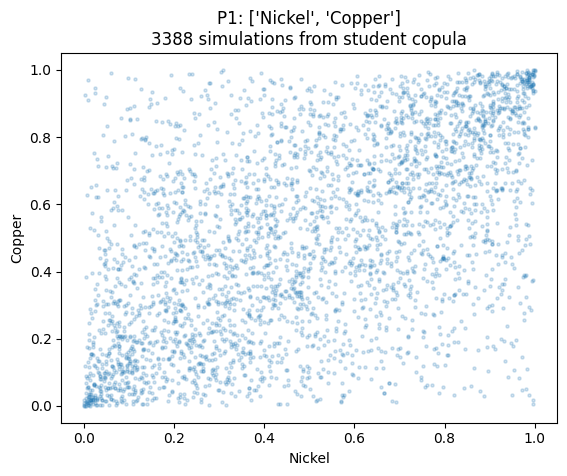

Portfolio_id: P2, assets: ['Brent Oil', 'Gas US']


f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: invalid value encountered in matmul
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\elliptical\student.py:176: RuntimeWarning: invalid value encountered in subtract
  d = mvt.logpdf(q, cov=sigma, df=df) - t.logpdf(q, df=df).sum(1)


         Brent Oil       Gas US
count  3388.000000  3388.000000
mean      0.501316     0.501121
std       0.288368     0.288277
min       0.000032     0.000010
25%       0.252541     0.250235
50%       0.484679     0.506638
75%       0.752533     0.749521
max       1.000000     1.000000
Student Copula Summary
Student Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 4.669

 Correlation Matrix 
1.00000 0.10552
0.10552 1.00000



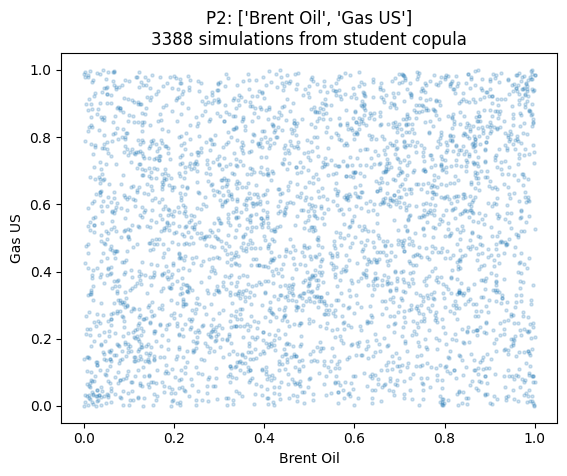

Portfolio_id: P3, assets: ['Gold', 'Silver']


f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: invalid value encountered in matmul
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              Gold       Silver
count  3388.000000  3388.000000
mean      0.500689     0.500883
std       0.288347     0.288418
min       0.000007     0.000008
25%       0.253182     0.254240
50%       0.499630     0.500298
75%       0.749555     0.748668
max       1.000000     1.000000
Student Copula Summary
Student Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 4.669

 Correlation Matrix 
1.000000 0.795813
0.795813 1.000000



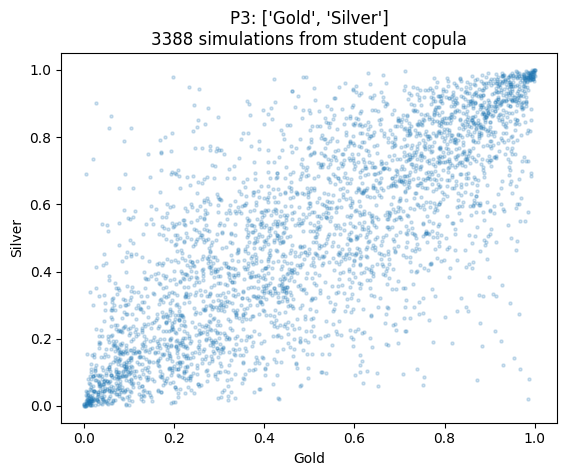

Portfolio_id: P4, assets: ['Nickel', 'Copper', 'Gold']


f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: invalid value encountered in matmul
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\elliptical\student.py:176: RuntimeWarning: invalid value encountered in subtract
  d = mvt.logpdf(q, cov=sigma, df=df) - t.logpdf(q, df=df).sum(1)


            Nickel       Copper         Gold
count  3388.000000  3388.000000  3388.000000
mean      0.501595     0.500596     0.500689
std       0.288286     0.288301     0.288347
min       0.000014     0.000005     0.000007
25%       0.252589     0.252413     0.253182
50%       0.496716     0.494437     0.499630
75%       0.750556     0.749787     0.749555
max       1.000000     1.000000     1.000000
Student Copula Summary
Student Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 4.669

 Correlation Matrix 
1.000000 0.554649 0.194677
0.554649 1.000000 0.241810
0.194677 0.241810 1.000000



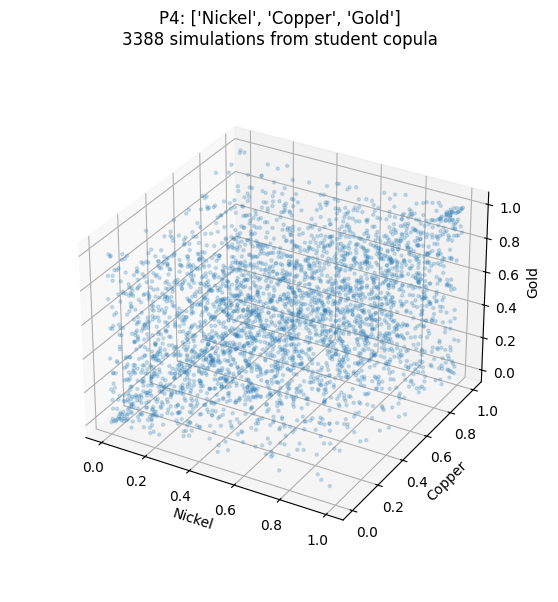

Portfolio_id: P5, assets: ['Nickel', 'Copper', 'Silver']


f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: invalid value encountered in matmul
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\elliptical\student.py:176: RuntimeWarning: invalid value encountered in subtract
  d = mvt.logpdf(q, cov=sigma, df=df) - t.logpdf(q, df=df).sum(1)


            Nickel       Copper       Silver
count  3388.000000  3388.000000  3388.000000
mean      0.501595     0.500596     0.500883
std       0.288286     0.288301     0.288418
min       0.000014     0.000005     0.000008
25%       0.252589     0.252413     0.254240
50%       0.496716     0.494437     0.500298
75%       0.750556     0.749787     0.748668
max       1.000000     1.000000     1.000000
Student Copula Summary
Student Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 4.669

 Correlation Matrix 
1.000000 0.554649 0.296202
0.554649 1.000000 0.382720
0.296202 0.382720 1.000000



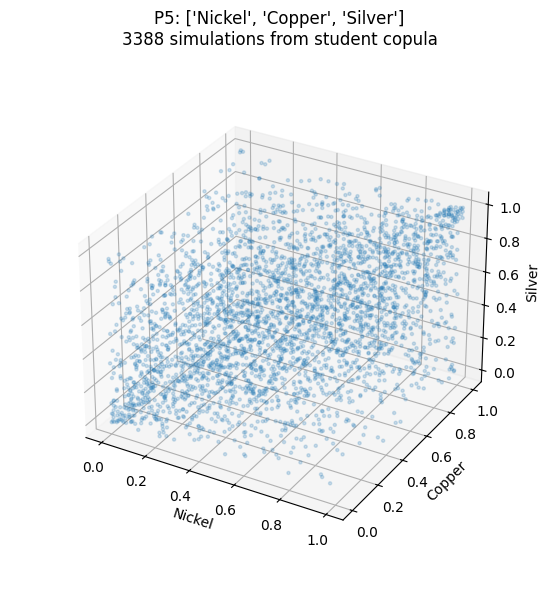

Portfolio_id: P6, assets: ['Brent Oil', 'Gas US', 'Gold']


f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: invalid value encountered in matmul
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\elliptical\student.py:176: RuntimeWarning: invalid value encountered in subtract
  d = mvt.logpdf(q, cov=sigma, df=df) - t.logpdf(q, df=df).sum(1)


         Brent Oil       Gas US         Gold
count  3388.000000  3388.000000  3388.000000
mean      0.501316     0.501121     0.500689
std       0.288368     0.288277     0.288347
min       0.000032     0.000010     0.000007
25%       0.252541     0.250235     0.253182
50%       0.484679     0.506638     0.499630
75%       0.752533     0.749521     0.749555
max       1.000000     1.000000     1.000000
Student Copula Summary
Student Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 4.669

 Correlation Matrix 
1.000000 0.105520 0.143958
0.105520 1.000000 0.000909
0.143958 0.000909 1.000000



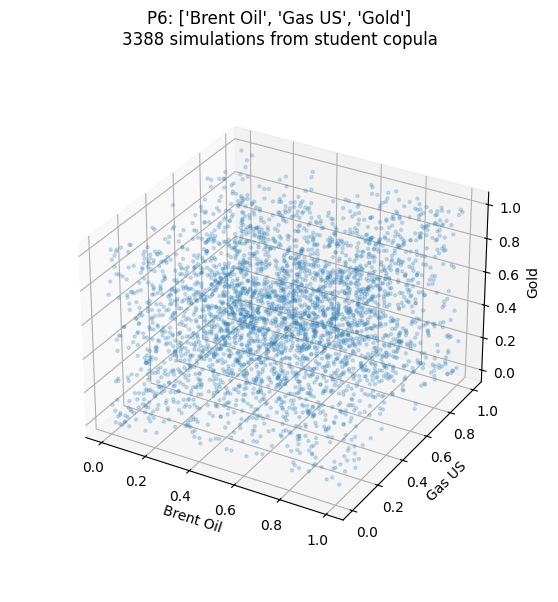

Portfolio_id: P7, assets: ['Brent Oil', 'Gas US', 'Silver']


f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: invalid value encountered in matmul
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


         Brent Oil       Gas US       Silver
count  3388.000000  3388.000000  3388.000000
mean      0.501316     0.501121     0.500883
std       0.288368     0.288277     0.288418
min       0.000032     0.000010     0.000008
25%       0.252541     0.250235     0.254240
50%       0.484679     0.506638     0.500298
75%       0.752533     0.749521     0.748668
max       1.000000     1.000000     1.000000
Student Copula Summary
Student Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 4.669

 Correlation Matrix 
1.000000 0.105520 0.213361
0.105520 1.000000 0.018516
0.213361 0.018516 1.000000



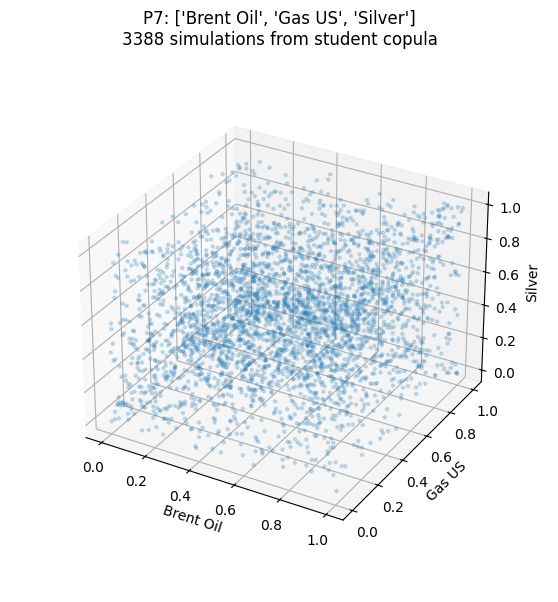

In [8]:
copula_simulations_dfs_cdf = {}
copula_simulations_dfs_values = {}
for portfolio, assets in SELECTED_PORTFOLIOS.items():
    print(f'Portfolio_id: {portfolio}, assets: {assets}')
    copula_dict = {
        'gaussian': GaussianCopula(dim=len(assets)),
        'student': StudentCopula(dim=len(assets)),
        'frank': FrankCopula(dim=len(assets)),
        'clayton': ClaytonCopula(dim=len(assets)),
        'gumbel': GumbelCopula(dim=len(assets))
    }
    copula = copula_dict[COPULA]
    copula.fit(X_train_kernel_cdf[assets], to_pobs=False, verbose=0)
    print(copula.summary())
    
    copula_simulations_dfs_cdf[portfolio] = copula.random(n=len(X_train), seed=RANDOM_SEED)

    copula_simulations_dfs_values[portfolio] = deepcopy(copula_simulations_dfs_cdf[portfolio])
    for col in copula_simulations_dfs_values[portfolio].columns:
        copula_simulations_dfs_values[portfolio][col] = copula_simulations_dfs_values[portfolio][col].apply(
            lambda cdf_val: get_inverse_cdf(cdf_val, df_kernel_cdf[col], df_kernel_xrange[col]))

    if len(assets)==2:
        plt.scatter(
            copula_simulations_dfs_cdf[portfolio][assets[0]],
            copula_simulations_dfs_cdf[portfolio][assets[1]],
            alpha=0.2,
            s=5)
        plt.xlabel(assets[0])
        plt.ylabel(assets[1])
        plt.title(
            f'{portfolio}: {assets}\n'
            f'{len(X_train)} simulations from {COPULA} copula')
        plt.show()
    elif len(assets)==3:

        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(
            copula_simulations_dfs_cdf[portfolio][assets[0]],
            copula_simulations_dfs_cdf[portfolio][assets[1]],
            copula_simulations_dfs_cdf[portfolio][assets[2]],
            s=5, alpha=0.2)
        ax.set_title(f'{portfolio}: {assets}\n'
            f'{len(X_train)} simulations from {COPULA} copula')
        ax.set_xlabel(assets[0])
        ax.set_ylabel(assets[1])
        ax.set_zlabel(assets[2], rotation=90)
        ax.set_box_aspect(aspect=None, zoom=0.85)
        #ax.zaxis.labelpad=-0.6
        plt.show()
    else: continue

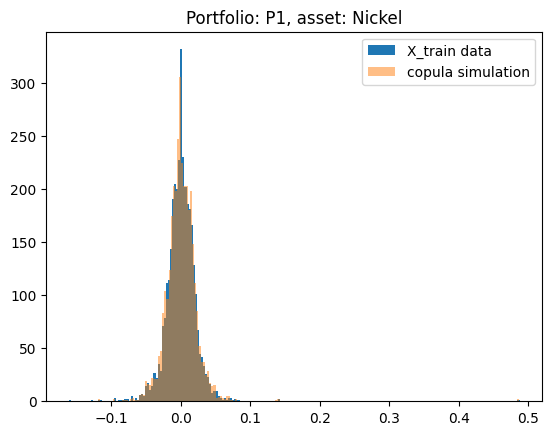

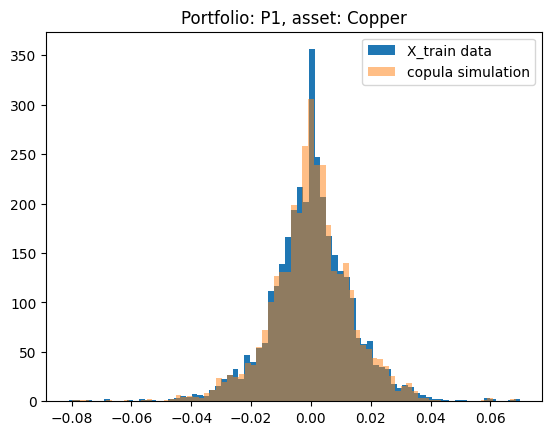

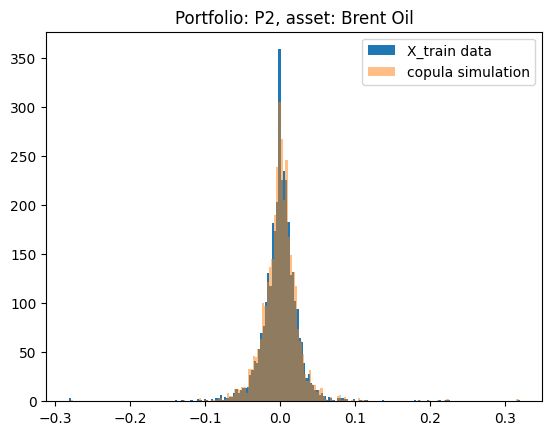

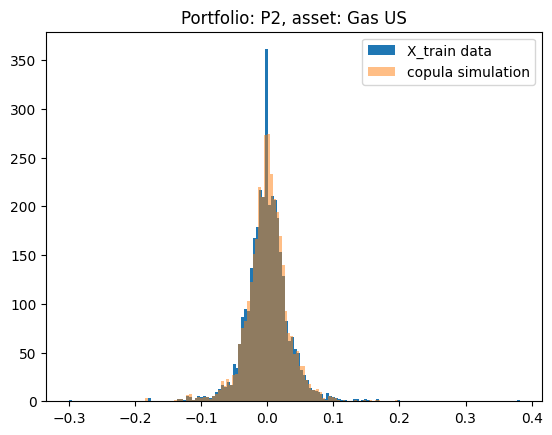

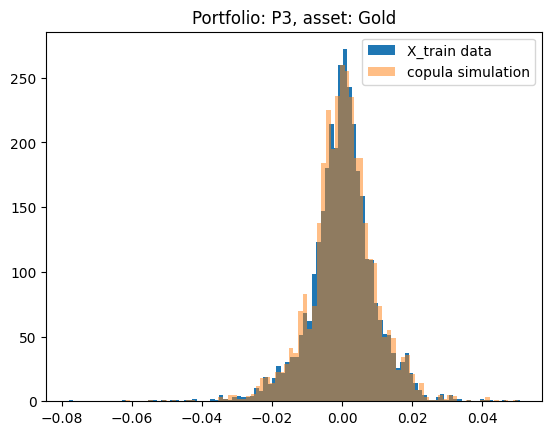

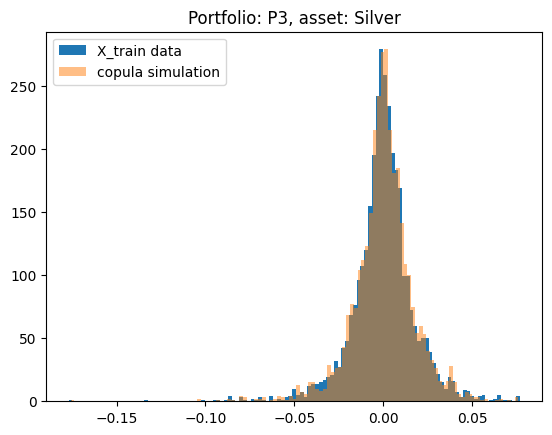

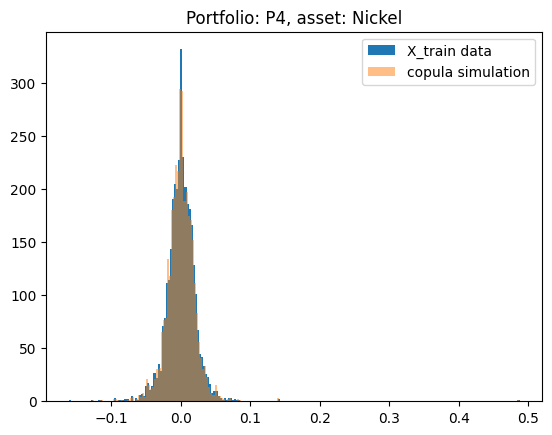

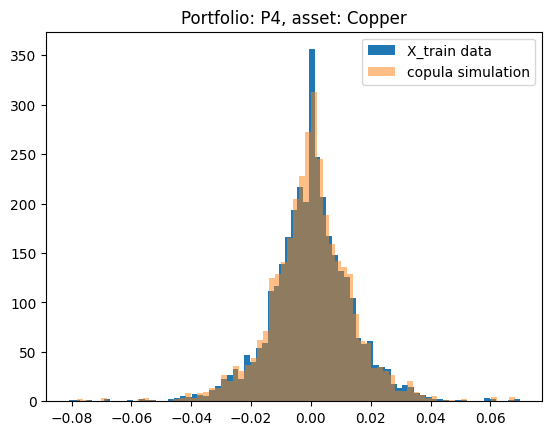

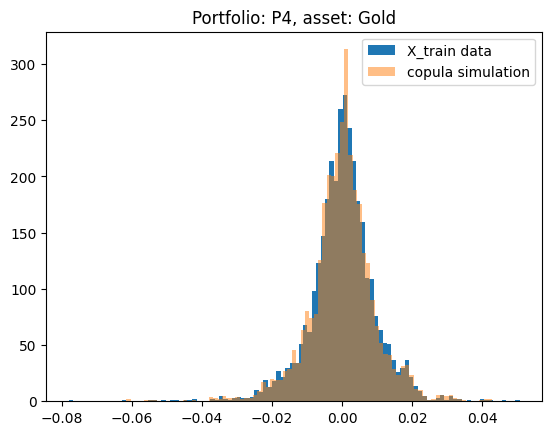

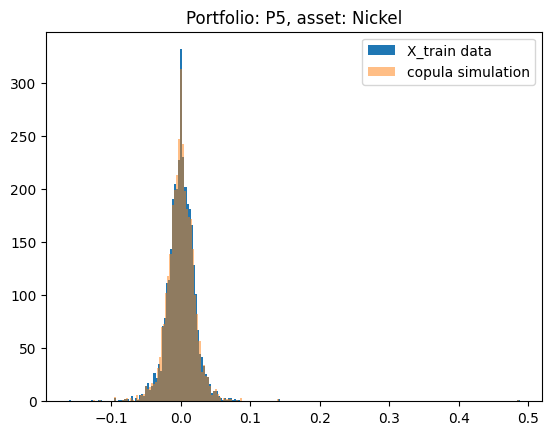

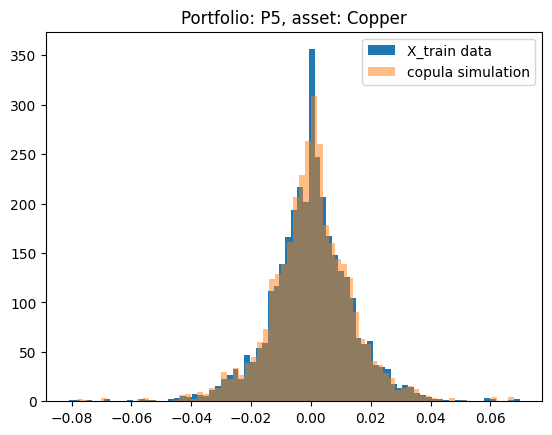

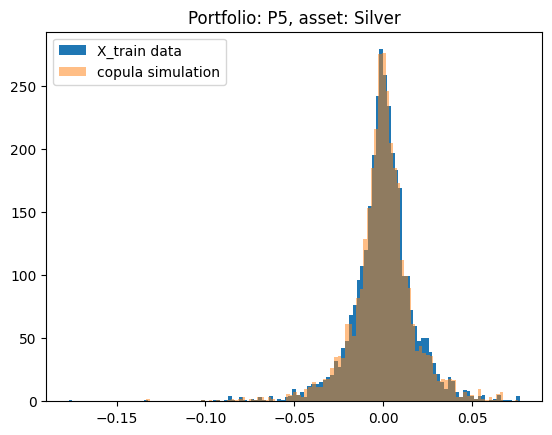

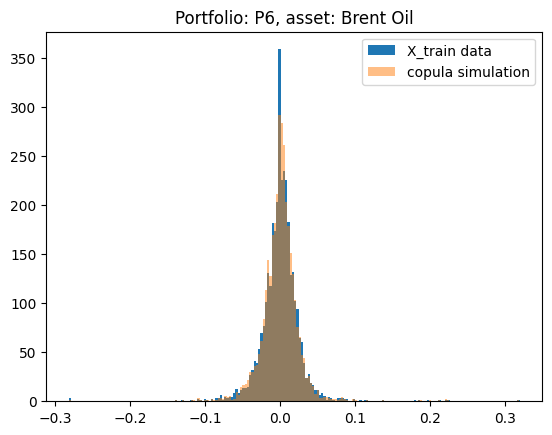

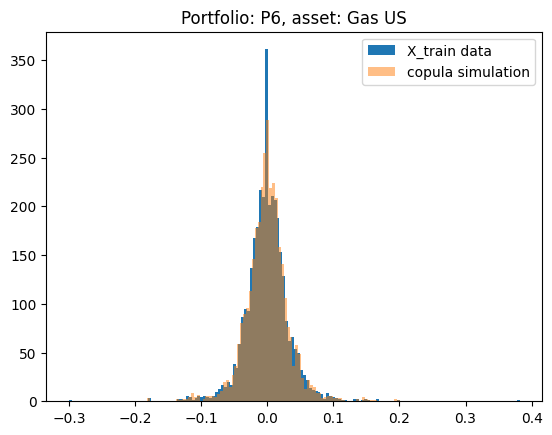

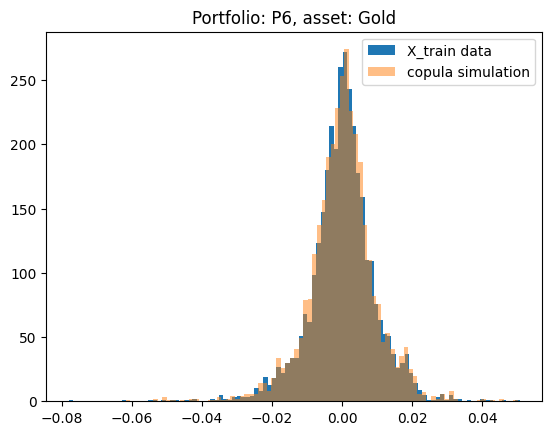

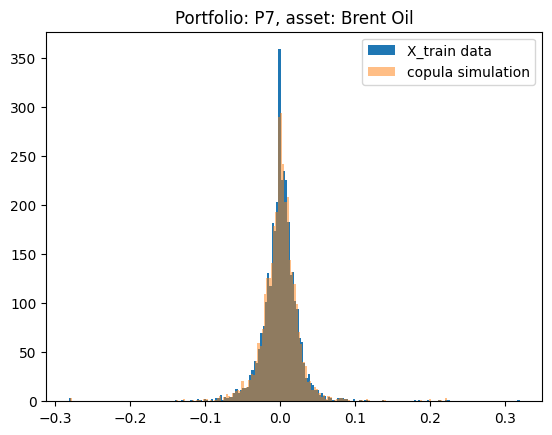

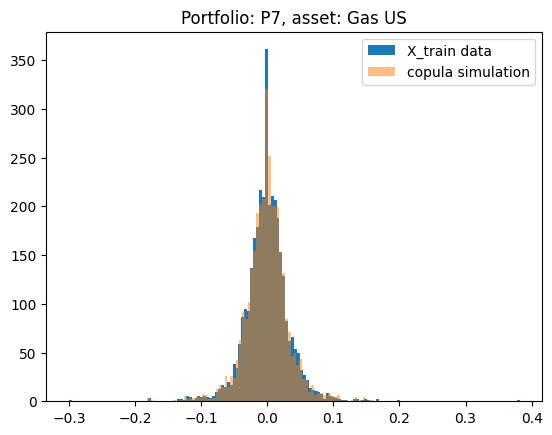

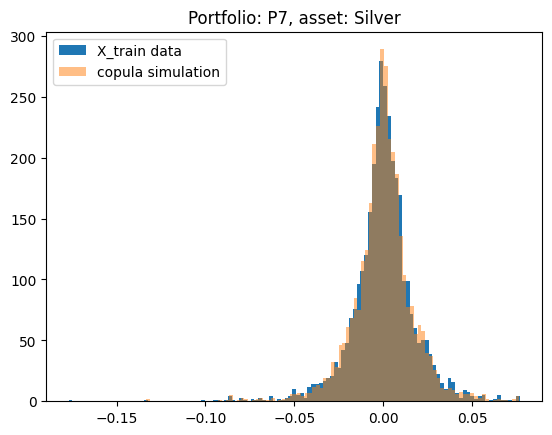

In [10]:
for portfolio_id, df in copula_simulations_dfs_values.items():
    for asset in df.columns:
        plt.title(f'Portfolio: {portfolio_id}, asset: {asset}')
        plt.hist(X_train[asset], bins='auto', label='X_train data')
        plt.hist(df[asset], bins='auto', label='copula simulation', alpha=0.5)
        plt.legend()
        plt.show()

# 4. Portfolio weight optimizations for classical Markowitz and Semiparametric

In [11]:
np.random.seed(RANDOM_SEED)

markowitz_weights = {}
copula_weights = {}
for portfolio, assets in SELECTED_PORTFOLIOS.items():
    # classic markowitz
    returns_markowitz = X_train[assets].mean()
    cov_markowitz = X_train[assets].cov()
    weights_markowitz = Variable(len(assets))
    risk_markowitz = quad_form(weights_markowitz, cov_markowitz)
    ef_markowitz = Problem(Minimize(risk_markowitz), [sum(weights_markowitz)==1, weights_markowitz >= 0]).solve()
    markowitz_weights[portfolio] = weights_markowitz.value

    # copula - new approach
    returns_copula = copula_simulations_dfs_values[portfolio].mean()
    # cov_copula = risk_models.corr_to_cov(dependency_matrix_copula, stdevs=copula_simulations_dfs[portfolio].std())
    cov_copula = copula_simulations_dfs_values[portfolio].cov()
    weights_copula = Variable(len(assets))
    risk_copula = quad_form(weights_copula, cov_copula)
    ef_copula = Problem(Minimize(risk_copula), [sum(weights_copula)==1, weights_copula >= 0]).solve()
    copula_weights[portfolio] = weights_copula.value

# 5. Portfolio testing

P1


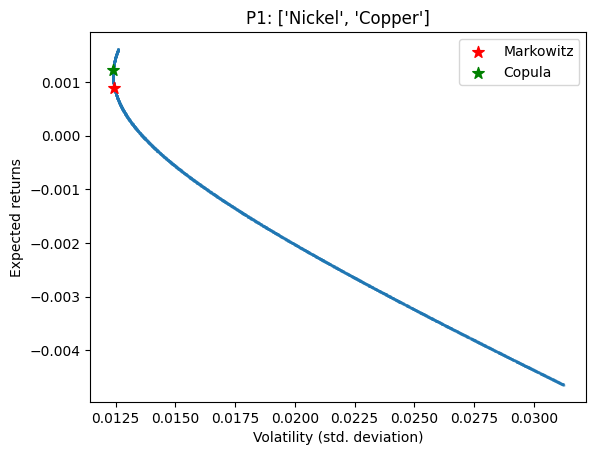

P2


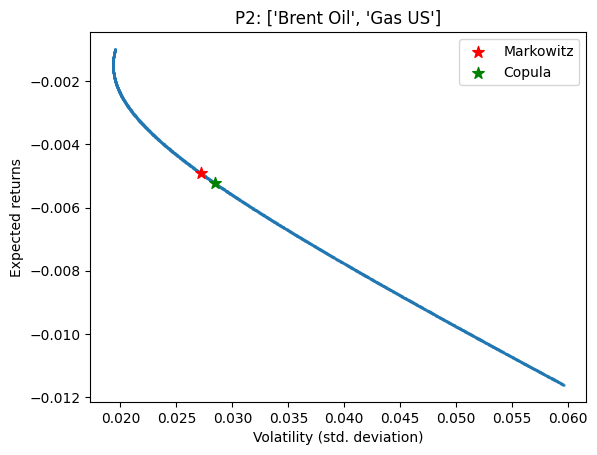

P3


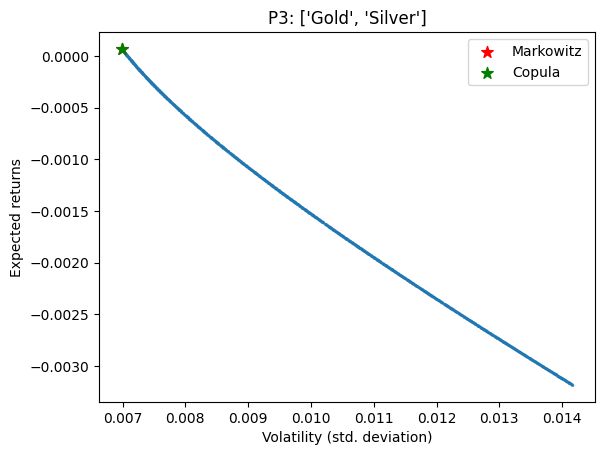

P4


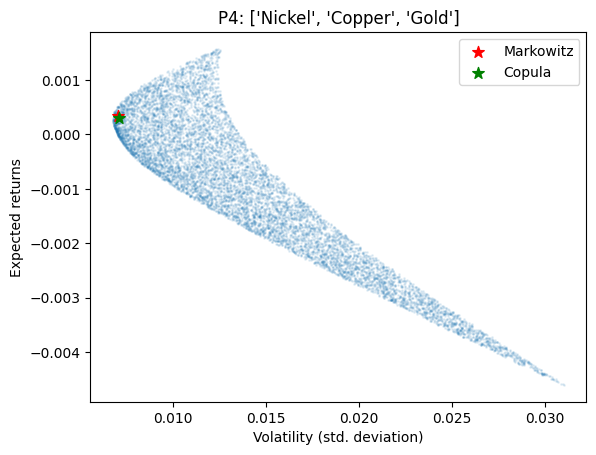

P5


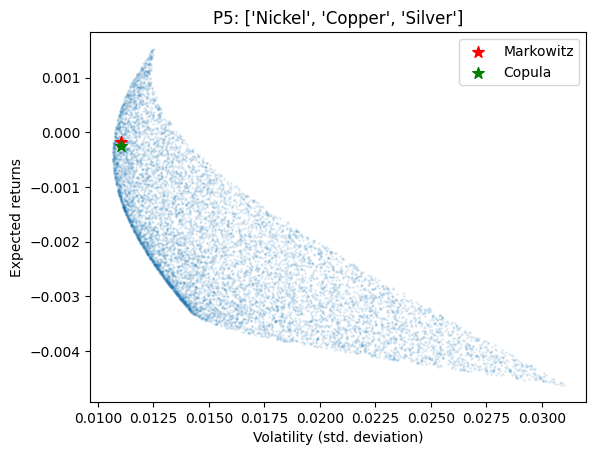

P6


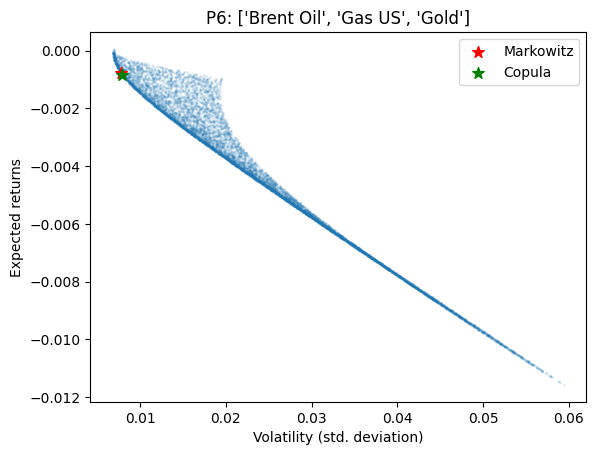

P7


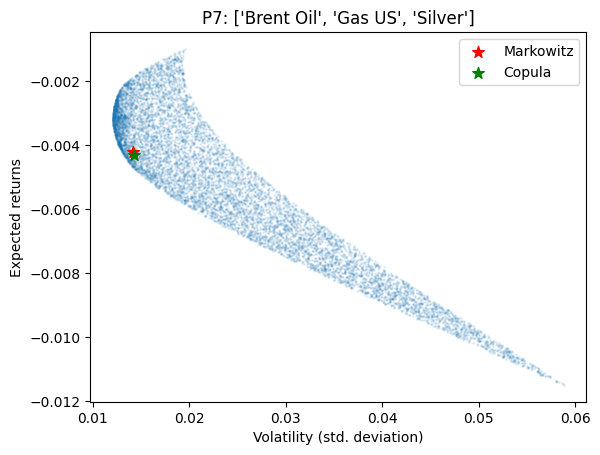

In [12]:
np.random.seed(RANDOM_SEED)

testing_df = pd.DataFrame()
for portfolio, assets in SELECTED_PORTFOLIOS.items():
    testing_portfolio = X_test[assets]
    print(portfolio)
    testing_markowitz_return = (markowitz_weights[portfolio]*np.array(testing_portfolio.mean())).sum()
    testing_markowitz_volatility = np.sqrt(
        np.dot(markowitz_weights[portfolio].T, np.dot(testing_portfolio.cov(), markowitz_weights[portfolio])))
    
    testing_copula_return = (copula_weights[portfolio]*np.array(testing_portfolio.mean())).sum()
    testing_copula_volatility = np.sqrt(
        np.dot(copula_weights[portfolio].T, np.dot(testing_portfolio.cov(), copula_weights[portfolio])))
    row = pd.DataFrame({
        'Portfolio': [portfolio],
        'Assets': [assets],
        'Markowitz weights': [markowitz_weights[portfolio]],
        'Copula weights': [copula_weights[portfolio]],
        'Markowitz return': [testing_markowitz_return],
        'Copula return': [testing_copula_return],
        'Markowitz volatility': [testing_markowitz_volatility],
        'Copula volatility': [testing_copula_volatility]
    })
    testing_df = pd.concat([testing_df, row], ignore_index=True)


    simulated_df = pd.DataFrame()
    for i in range(0, WEIGHT_SIMULATIONS):
        weight_sim = np.random.dirichlet(np.ones(len(assets)), size=1)[0]

        portfolio_return = (weight_sim*np.array(testing_portfolio.mean())).sum()
        portfolio_volatility = np.sqrt(np.dot(weight_sim.T, np.dot(testing_portfolio.cov(), weight_sim)))

        row = pd.DataFrame({
            'weights': [weight_sim],
            'exp_return': [portfolio_return],
            'volatility': [portfolio_volatility]
        })
        simulated_df = pd.concat([simulated_df, row], ignore_index=True)

    plt.title(f'{portfolio}: {assets}')
    plt.scatter(x=simulated_df['volatility'], y=simulated_df['exp_return'], alpha=0.1, s=1)
    plt.scatter(x=testing_markowitz_volatility, y=testing_markowitz_return, s=75, marker='*', color='red', label='Markowitz')
    plt.scatter(x=testing_copula_volatility, y=testing_copula_return, s=75, marker='*', color='green', label='Copula')
    plt.xlabel('Volatility (std. deviation)')
    plt.ylabel('Expected returns')
    plt.legend()
   # plt.title(f'Optimal weights: {printable_weights}\n'
   #         f'Exp return: {round(opt_return,3)}, Volatility: {round(opt_volatility,3)}')
    plt.show()


benchmark = X_test[SELECTED_BENCHMARK]
benchmark_return = benchmark.mean()
benchmark_volatility = benchmark.std()
testing_df[f'Benchmark: {SELECTED_BENCHMARK} return'] = benchmark_return
testing_df[f'Benchmark: {SELECTED_BENCHMARK} volatility'] = benchmark_volatility
testing_df['Markowitz Sharpe'] = ((
    testing_df['Markowitz return'] - testing_df[f'Benchmark: {SELECTED_BENCHMARK} return'])
    /testing_df['Markowitz volatility'])
testing_df['Copula Sharpe'] = ((
    testing_df['Copula return'] - testing_df[f'Benchmark: {SELECTED_BENCHMARK} return'])
    /testing_df['Copula volatility'])

# Add seperate tables for Markowitz and Copula for easier data visualization
markowitz_testing_df, copula_testing_df = deepcopy(testing_df), deepcopy(testing_df)
markowitz_testing_df['Portfolio'] = markowitz_testing_df['Portfolio']+'.m'
markowitz_testing_df = markowitz_testing_df[
    ['Portfolio', 'Assets', 'Markowitz weights', 'Markowitz return', 'Markowitz volatility', 'Markowitz Sharpe']]
copula_testing_df['Portfolio'] = copula_testing_df['Portfolio']+'.c'
copula_testing_df = copula_testing_df[
    ['Portfolio', 'Assets', 'Copula weights', 'Copula return', 'Copula volatility', 'Copula Sharpe']]


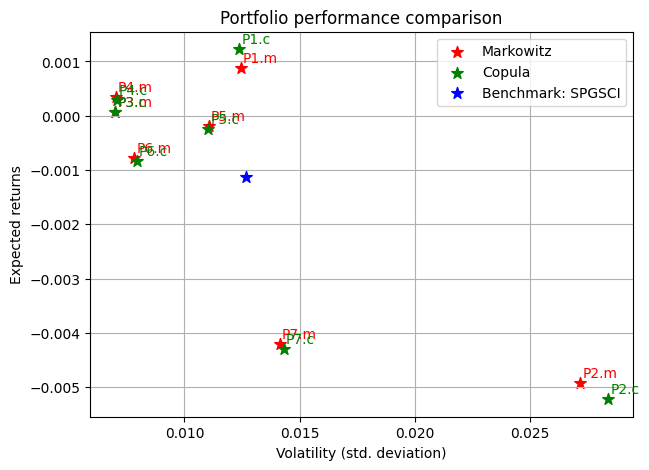

In [13]:
#plt.style.use('ggplot')
plt.figure(figsize=(7,5))
# Markowitz portfolios
plt.scatter(
    x=markowitz_testing_df['Markowitz volatility'],
    y=markowitz_testing_df['Markowitz return'], s=75, marker='*', color='red', label='Markowitz')
for i in range(len(markowitz_testing_df)): 
    plt.annotate(
        markowitz_testing_df['Portfolio'][i],
        (markowitz_testing_df['Markowitz volatility'][i]+0.0001, markowitz_testing_df['Markowitz return'][i]+0.0001),
        color='red') 
# Copula portfolio
plt.scatter(
    x=copula_testing_df['Copula volatility'],
    y=copula_testing_df['Copula return'], s=75, marker='*', color='green', label='Copula')
for i in range(len(copula_testing_df)): 
    plt.annotate(
        copula_testing_df['Portfolio'][i],
        (copula_testing_df['Copula volatility'][i]+0.0001, copula_testing_df['Copula return'][i]+0.0001),
        color='green')
# Benchmark
plt.scatter(x=benchmark_volatility, y=benchmark_return, s=75, marker='*', color='blue', label=f'Benchmark: {SELECTED_BENCHMARK}')

plt.title('Portfolio performance comparison')
plt.grid()
plt.legend()
plt.xlabel('Volatility (std. deviation)')
plt.ylabel('Expected returns')
plt.show()

In [14]:
testing_df

,Portfolio,Assets,Markowitz weights,Copula weights,Markowitz return,Copula return,Markowitz volatility,Copula volatility,Benchmark: SPGSCI return,Benchmark: SPGSCI volatility,Markowitz Sharpe,Copula Sharpe
0,P1,"[Nickel, Copper]","[0.11617258901376326, 0.8838274109862367]","[0.06195120241016062, 0.9380487975898394]",0.000886,0.001225,0.012443,0.012392,-0.001127,0.012666,0.161782,0.189830
1,P2,"[Brent Oil, Gas US]","[0.6295683044292459, 0.37043169557075406]","[0.6007604017210908, 0.3992395982789092]",-0.004916,-0.005223,0.027186,0.028411,-0.001127,0.012666,-0.139367,-0.144153
2,P3,"[Gold, Silver]","[1.0, 2.981555903564778e-24]","[1.0, 3.0086609517479387e-24]",0.000070,0.000070,0.006987,0.006987,-0.001127,0.012666,0.171280,0.171280
3,P4,"[Nickel, Copper, Gold]","[0.023469526719340324, 0.24929913939933515, 0....","[0.03125311100579825, 0.24301871764888655, 0.7...",0.000344,0.000297,0.007014,0.007059,-0.001127,0.012666,0.209706,0.201777
4,P5,"[Nickel, Copper, Silver]","[0.07691998924346892, 0.6491404647333063, 0.27...","[0.07570828717305957, 0.6346691244737211, 0.28...",-0.000182,-0.000250,0.011055,0.011021,-0.001127,0.012666,0.085460,0.079588
5,P6,"[Brent Oil, Gas US, Gold]","[0.06796957361768792, 0.06665632103913237, 0.8...","[0.08032364139623345, 0.07017634721530264, 0.8...",-0.000780,-0.000834,0.007803,0.007932,-0.001127,0.012666,0.044438,0.036908
6,P7,"[Brent Oil, Gas US, Silver]","[0.21376301180274818, 0.17633135219804225, 0.6...","[0.19679126504353436, 0.18306372960471637, 0.6...",-0.004198,-0.004292,0.014137,0.014305,-0.001127,0.012666,-0.217239,-0.221281


In [15]:
rounded_testing_df = deepcopy(testing_df)
rounded_testing_df['Markowitz weights'] = [np.around(i, 4) for i in testing_df['Markowitz weights'].values]
rounded_testing_df['Copula weights'] = [np.around(i, 4) for i in testing_df['Copula weights'].values]

rounded_testing_df

,Portfolio,Assets,Markowitz weights,Copula weights,Markowitz return,Copula return,Markowitz volatility,Copula volatility,Benchmark: SPGSCI return,Benchmark: SPGSCI volatility,Markowitz Sharpe,Copula Sharpe
0,P1,"[Nickel, Copper]","[0.1162, 0.8838]","[0.062, 0.938]",0.000886,0.001225,0.012443,0.012392,-0.001127,0.012666,0.161782,0.189830
1,P2,"[Brent Oil, Gas US]","[0.6296, 0.3704]","[0.6008, 0.3992]",-0.004916,-0.005223,0.027186,0.028411,-0.001127,0.012666,-0.139367,-0.144153
2,P3,"[Gold, Silver]","[1.0, 0.0]","[1.0, 0.0]",0.000070,0.000070,0.006987,0.006987,-0.001127,0.012666,0.171280,0.171280
3,P4,"[Nickel, Copper, Gold]","[0.0235, 0.2493, 0.7272]","[0.0313, 0.243, 0.7257]",0.000344,0.000297,0.007014,0.007059,-0.001127,0.012666,0.209706,0.201777
4,P5,"[Nickel, Copper, Silver]","[0.0769, 0.6491, 0.2739]","[0.0757, 0.6347, 0.2896]",-0.000182,-0.000250,0.011055,0.011021,-0.001127,0.012666,0.085460,0.079588
5,P6,"[Brent Oil, Gas US, Gold]","[0.068, 0.0667, 0.8654]","[0.0803, 0.0702, 0.8495]",-0.000780,-0.000834,0.007803,0.007932,-0.001127,0.012666,0.044438,0.036908
6,P7,"[Brent Oil, Gas US, Silver]","[0.2138, 0.1763, 0.6099]","[0.1968, 0.1831, 0.6201]",-0.004198,-0.004292,0.014137,0.014305,-0.001127,0.012666,-0.217239,-0.221281
